Mounted at /content/drive
Training new model...
Confusion Matrix:
[[ 96  33]
 [ 24 158]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       129
           1       0.83      0.87      0.85       182

    accuracy                           0.82       311
   macro avg       0.81      0.81      0.81       311
weighted avg       0.82      0.82      0.82       311

Cross-Validation Scores: [0.77108434 0.81124498 0.82329317 0.81526104 0.80241935]
Mean CV Score: 0.8046605777950513


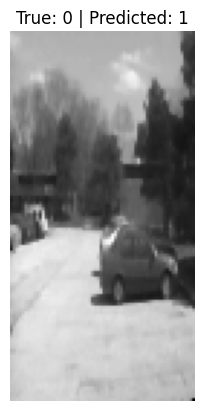

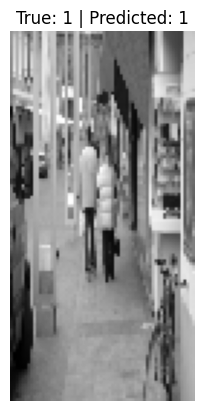

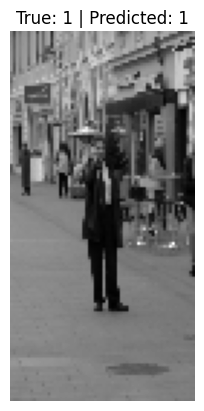

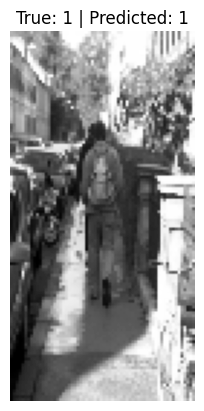

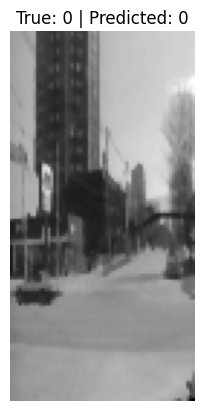

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

drive.mount('/content/drive')

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.medianBlur(img, 5)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (64, 128))
            images.append(img)
            labels.append(label)
    return images, labels

pedestrian_images, pedestrian_labels = load_images_from_folder("/content/drive/MyDrive/Colab Notebooks/pedestrian detection project/pos", 1)
non_pedestrian_images, non_pedestrian_labels = load_images_from_folder("/content/drive/MyDrive/Colab Notebooks/pedestrian detection project/neg", 0)

images = np.array(pedestrian_images + non_pedestrian_images)
labels = np.array(pedestrian_labels + non_pedestrian_labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def segment_image(img):
    blurred = cv2.medianBlur(img, 5)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

X_train_segmented = np.array([segment_image(img) for img in X_train])
X_test_segmented = np.array([segment_image(img) for img in X_test])

def extract_hog_features(images):
    hog = cv2.HOGDescriptor()
    features = []
    for img in images:
        h = hog.compute(img)
        features.append(h.flatten())
    return np.array(features)

hog_features_train = extract_hog_features(X_train_segmented)
hog_features_test = extract_hog_features(X_test_segmented)

X_train_features = hog_features_train
X_test_features = hog_features_test

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

model_path = "/content/drive/MyDrive/Colab Notebooks/pedestrian detection projec/pedestrian_detector.pkl"
if os.path.exists(model_path):
    print("Loading existing model...")
    clf = joblib.load(model_path)
else:
    print("Training new model...")
    svc = SVC(kernel='rbf', probability=True)
    param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]}
    grid = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits=5))
    grid.fit(X_train_pca, y_train)
    clf = grid.best_estimator_
    #joblib.dump(clf, model_path)
    #print(f"Model saved as '{model_path}'")

y_pred = clf.predict(X_test_pca)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

def visualize_results(images, labels, predictions, num_samples=5):
    for i in range(num_samples):
        plt.figure()
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {labels[i]} | Predicted: {predictions[i]}")
        plt.axis('off')
    plt.show()

visualize_results(X_test, y_test, y_pred)